In [74]:

import pandas as pd
import configs_py3 as configs
import matplotlib.pyplot as plt

import numpy as np
import utilities as utils
import json
from datetime import date

In [49]:
def get_thresholded_output(original_model_outputs, softmax_outputs, threshold=0.5):
    thresholded_model_outputs = []
    for idx in range(len(softmax_outputs)):
        
        if softmax_outputs[idx] < threshold:
            thresholded_model_outputs.append("ABSTAIN")
        else:
            thresholded_model_outputs.append(original_model_outputs[idx])
    return thresholded_model_outputs

In [50]:
val_df, original_model_outputs, softmax_outputs = utils.get_raw_val_prediction()

KeyboardInterrupt: 

In [ ]:
val_df

,level_0,index,answer_type,answers,image_id,multiple_choice_answer,question_id,question_type,random_question_id,random_question,original_question,original_model_outputs,softmax_outputs
0,1000,1000,other,"[{u'answer': u'white', u'answer_confidence': u...",370980,human,370980002,what kind of,383494000,What type of animal is hugging the bear?,What kind of baby is this?,white,0.225494
1,1001,1001,other,"[{u'answer': u'cookie', u'answer_confidence': ...",192809,birthday,192809005,what kind of,135057003,Is this indoors or outdoors?,What kind of candies are on the cake?,chocolate,0.292533
2,1002,1002,other,"[{u'answer': u'nothing', u'answer_confidence':...",147375,laptop,147375001,what does the,281221003,What color is the giraffe?,What does the boy have in his hand?,laptop,0.947981
3,1003,1003,other,"[{u'answer': u'christmas', u'answer_confidence...",551791,christmas,551791000,what,445594001,What is this dog laying on?,What holiday decorations are visible?,christmas,0.998209
4,1004,1004,other,"[{u'answer': u'white', u'answer_confidence': u...",333888,white,333888000,what color is,142856001,What is the paper called under the pizza?,What color is dominant?,white,0.656914
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1995,1995,other,"[{u'answer': u'boating', u'answer_confidence':...",79837,boating,79837027,what,260370005,What colors are the umbrella?,What hobby is shown?,black,0.338384
996,1996,1996,other,"[{u'answer': u'brown', u'answer_confidence': u...",455355,brown,455355002,what color is the,497969000,"Written in red at the top of the left, what is...",What color is the man on the right's horse?,nothing,0.234119
997,1997,1997,other,"[{u'answer': u'ruler', u'answer_confidence': u...",532403,ruler,532403007,what is the,172690003,Where are the people at?,What is the item that measures?,desk,0.362829
998,1998,1998,other,"[{u'answer': u'lady on right', u'answer_confid...",326217,lady on right,326217001,which,364307006,What kinds of food items are on the plate?,Which of the people is wearing a hat that woul...,fruit,0.856421


In [ ]:
abstain_ratio_dict = {}
for threshold in np.arange(0.1, 1.0, 0.1):
    threshold = round(threshold,1)
    thresholded_model_outputs = get_thresholded_output(original_model_outputs, softmax_outputs, threshold=threshold)
    val_df[f'thresholded_model_outputs_{threshold}'] = thresholded_model_outputs
   
    abstain_ratio_dict[threshold] = len(val_df[val_df[f'thresholded_model_outputs_{threshold}'] == "ABSTAIN"]) / len(val_df)
    print(f"Abstain ratio for threshold {threshold} is {abstain_ratio_dict[threshold]}")
val_df.to_csv(configs.output_path, index=False)

Abstain ratio for threshold 0.1 is 0.025
Abstain ratio for threshold 0.2 is 0.117
Abstain ratio for threshold 0.3 is 0.228
Abstain ratio for threshold 0.4 is 0.326
Abstain ratio for threshold 0.5 is 0.42
Abstain ratio for threshold 0.6 is 0.504
Abstain ratio for threshold 0.7 is 0.588
Abstain ratio for threshold 0.8 is 0.658
Abstain ratio for threshold 0.9 is 0.731


In [ ]:
# create results file in required format
val_df = pd.read_csv(configs.output_path, index_col=False)

results = []
for threshold in np.arange(0.1, 1.0, 0.1):
    threshold = round(threshold,1)
    for index, row in val_df.iterrows():
        question_id = row['question_id']
        answer = row[f'thresholded_model_outputs_{threshold}']
        result = {"question_id": question_id, "answer": answer}
        results.append(result)

    # store results in json file

    resFile = '%s/Results/%s%s_%s_%s_results_%s.json' %(configs.dataDir, configs.versionType, configs.taskType, 
                                                        configs.dataType, configs.dataSubType, threshold)
    json.dump(results, open(resFile, 'w'))


In [55]:
def get_eval_dicts(val_df):
    val_df = pd.read_csv(configs.output_path, index_col=False)
    accuracy_dict = {}
    abstain_acc_dict = {}
    abstain_y_true_dict = {}
    abstain_y_pred_dict = {}
    for threshold in np.arange(0.1, 1.0, 0.1):
        threshold = round(threshold,1)

        for index, row in val_df.iterrows():
            
            y_pred = row[f'thresholded_model_outputs_{threshold}']            
            y_true = row['multiple_choice_answer'] if index <= len(val_df)/2 else "ABSTAIN"
            
            
            abstain_y_true = 0  if index <= len(val_df)/2 else 1
            abstain_y_pred = 1 if y_pred == "ABSTAIN" else 0     
            
            
            if threshold not in abstain_y_true_dict:
                abstain_y_true_dict[threshold] = []
                abstain_y_pred_dict[threshold] = []
            abstain_y_true_dict[threshold].append(abstain_y_true)
            abstain_y_pred_dict[threshold].append(abstain_y_pred)
                   
            if y_true in y_pred:
                accuracy_dict[threshold] = accuracy_dict.get(threshold, 0) + 1
            
            if y_true == "ABSTAIN" and y_pred == "ABSTAIN":
                abstain_acc_dict[threshold] = abstain_acc_dict.get(threshold, 0) + 1
            elif "ABSTAIN" not in y_true and "ABSTAIN" not in y_pred:
                abstain_acc_dict[threshold] = abstain_acc_dict.get(threshold, 0) + 1
                
        accuracy_dict[threshold] = accuracy_dict[threshold] / len(val_df)
        abstain_acc_dict[threshold] = abstain_acc_dict[threshold] / len(val_df)
    return accuracy_dict, abstain_acc_dict, abstain_y_true_dict, abstain_y_pred_dict


In [56]:
accuracy_dict, abstain_acc_dict, abstain_y_true_dict, abstain_y_pred_dict = get_eval_dicts(val_df)

In [58]:
accuracy_dict, abstain_acc_dict

({0.1: 0.359,
  0.2: 0.415,
  0.3: 0.49,
  0.4: 0.532,
  0.5: 0.57,
  0.6: 0.603,
  0.7: 0.613,
  0.8: 0.634,
  0.9: 0.633},
 {0.1: 0.51,
  0.2: 0.542,
  0.3: 0.591,
  0.4: 0.607,
  0.5: 0.625,
  0.6: 0.645,
  0.7: 0.641,
  0.8: 0.653,
  0.9: 0.644})

In [60]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix


for threshold in np.arange(0.1, 1.0, 0.1):
    threshold = round(threshold,1)
    print(f"Threshold: {threshold}")
    print(classification_report(abstain_y_true_dict[threshold], abstain_y_pred_dict[threshold]))
    print(confusion_matrix(abstain_y_true_dict[threshold], abstain_y_pred_dict[threshold]))
    

Threshold: 0.1
              precision    recall  f1-score   support

           0       0.51      0.98      0.67       501
           1       0.68      0.03      0.06       499

    accuracy                           0.51      1000
   macro avg       0.59      0.51      0.37      1000
weighted avg       0.59      0.51      0.37      1000

[[493   8]
 [482  17]]
Threshold: 0.2
              precision    recall  f1-score   support

           0       0.52      0.92      0.67       501
           1       0.68      0.16      0.26       499

    accuracy                           0.54      1000
   macro avg       0.60      0.54      0.46      1000
weighted avg       0.60      0.54      0.46      1000

[[463  38]
 [420  79]]
Threshold: 0.3
              precision    recall  f1-score   support

           0       0.56      0.86      0.68       501
           1       0.70      0.32      0.44       499

    accuracy                           0.59      1000
   macro avg       0.63      0.59    

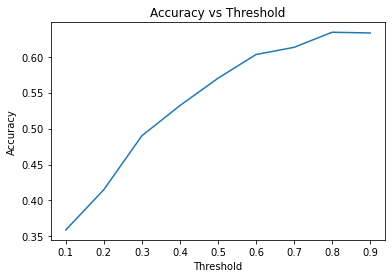

In [ ]:
plt.plot(list(accuracy_dict.keys()), list(accuracy_dict.values()), label="Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Threshold")
plt.show()

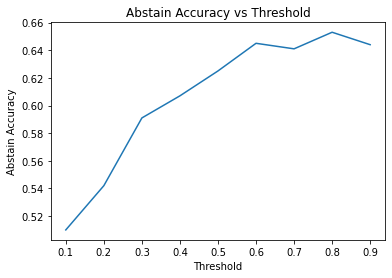

In [ ]:
plt.plot(list(abstain_acc_dict.keys()), list(abstain_acc_dict.values()), label="Abstain Accuracy")
plt.xlabel("Threshold")
plt.ylabel("Abstain Accuracy")
plt.title("Abstain Accuracy vs Threshold")
plt.show()

In [70]:
threshold = 0.5

raw_output = pd.read_csv(configs.output_path, index_col=False)[f"thresholded_model_outputs_{threshold}"]

related_question_output = raw_output[:len(raw_output)//2]
unrelated_question_output = raw_output[len(raw_output)//2:]

In [71]:
unrelated_question_output.value_counts()

ABSTAIN     273
nothing      26
white        22
black        14
brown         9
           ... 
banana        1
swimming      1
modern        1
night         1
nike          1
Name: thresholded_model_outputs_0.5, Length: 114, dtype: int64

In [72]:
related_question_output.value_counts()

ABSTAIN    147
white       16
red         15
blue        13
yellow      11
          ... 
stripes      1
dragon       1
knife        1
beard        1
iphone       1
Name: thresholded_model_outputs_0.5, Length: 187, dtype: int64

In [76]:
distribution_of_answers_df = pd.DataFrame({"related_question_output": related_question_output.value_counts(), 
                                        "unrelated_question_output": unrelated_question_output.value_counts()})
distribution_of_answers_df.to_csv("%s/output/%s-distribution-of-answers.csv" % (configs.ROOT, date.today()))

In [89]:
len(distribution_of_answers_df)

247

In [88]:
# show top 25 answers
distribution_of_answers_df.sort_values(by="unrelated_question_output", ascending=False).head(25)

,related_question_output,unrelated_question_output
ABSTAIN,147.0,273.0
nothing,2.0,26.0
white,16.0,22.0
black,7.0,14.0
brown,8.0,9.0
blue,13.0,7.0
nowhere,NaN,7.0
green,9.0,6.0
0,NaN,4.0
outside,NaN,3.0


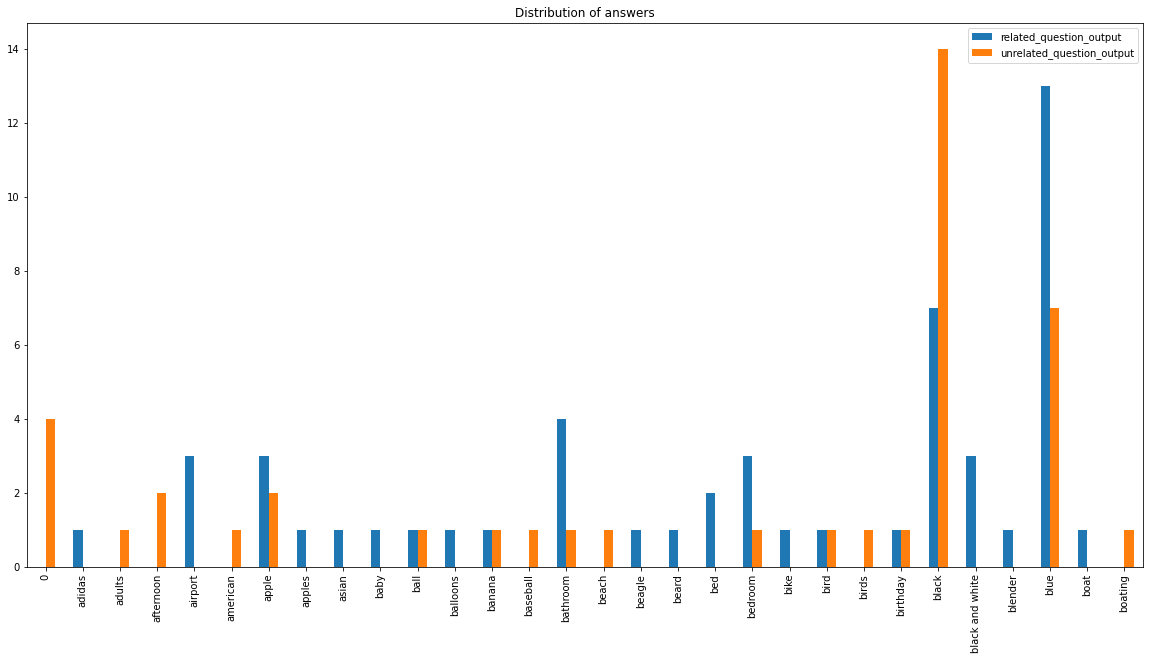

In [92]:
# plot histogram after removing ABSTAIN
distribution_of_answers_df.drop(["ABSTAIN"]).head(30).plot(kind='bar', figsize=(20,10), title="Distribution of answers")
plt.show()